In [1]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from unet_parts import *
from unet_parts_att_transformer import *
from unet_parts_att_multiscale import *
from transformerskip import tskip
import random
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(20)
np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed(20)
device

device(type='cuda')

In [2]:
torch.cuda.device_count()

1

In [3]:
import cv2
import glob
from tqdm import tqdm
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage


In [4]:
from torchmetrics import Dice
import torch.optim as optim

In [5]:
# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         intersection = (inputs * targets).sum()                            
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
#         return 1 - dice
# class DiceLoss(nn.Module):
#     def __init__(self, weight=None, size_average=True):
#         super(DiceLoss, self).__init__()

#     def forward(self, inputs, targets, smooth=1):
        
#         #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
#         #flatten label and prediction tensors
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
        
#         intersection = (inputs * targets).sum()                            
#         dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
#         return 1 - dice
def dice_loss(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return 1 - dice
def dice_coeff(pred, target):
    smooth = 1.#1e-5
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice


# def dice_loss(pred, target):
#     smooth = 1.#1e-5
#     intersection = (pred * target).sum()
#     union = pred.sum() + target.sum()
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1 - dice
# def dice_coeff(pred, target):
#     smooth = 1.#1e-5
#     intersection = (pred * target).sum()
#     union = pred.sum() + target.sum()
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return dice

In [6]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import albumentations as A
import time
from tqdm.notebook import tqdm
from torchsummary import summary




In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
# Define custom dataset class

def parse_image(img_path):
    img = np.load(img_path)
    img = np.expand_dims(img, axis=2)
    img = img.astype(np.float32)
    d = np.amax(img)- np.amin(img)
    img = (img-np.amin(img))/d
    img = ToTensor()(img)
    return img

def parse_mask(img_path):
    mask = np.load(img_path)
    mask = np.expand_dims(mask, axis=2)
    mask = np.where(mask>0,1,mask)
    mask = mask.astype(np.uint8)
    mask = torch.from_numpy(mask).long()
    return mask

class DataGen(Dataset):
    def __init__(self, image_size, images_path , mask_path, transform=None):
        self.image_size = image_size
        self.images_path = images_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, index):
        image = parse_image(self.images_path[index])
        mask = parse_mask(self.mask_path[index])

        if self.transform is not None:
            image = self.transform(image)

        return image, mask


In [8]:
trainpath = sorted(glob.glob(r"/home/rabeea/spleen_2d/tr_img/*.npy", recursive = True))
trainpath_m = sorted(glob.glob(r"/home/rabeea/spleen_2d/tr_mask/*.npy", recursive = True))
valpath = sorted(glob.glob(r"/home/rabeea/spleen_2d/val_img/*.npy", recursive = True))
valpath_m = sorted(glob.glob(r"/home/rabeea/spleen_2d/val_mask/*.npy", recursive = True))
testpath = sorted(glob.glob(r"/home/rabeea/spleen_2d/ts_img/*.npy", recursive = True))
testpath_m = sorted(glob.glob(r"/home/rabeea/spleen_2d/ts_mask/*.npy", recursive = True))
print(len(trainpath), len(valpath), len(testpath))
print(valpath_m[:3])

2463 386 801
['/home/rabeea/spleen_2d/val_mask/spleen_10_0.npy', '/home/rabeea/spleen_2d/val_mask/spleen_10_1.npy', '/home/rabeea/spleen_2d/val_mask/spleen_10_10.npy']


In [9]:
image_size = (256,256)
batch_size = 1

epochs = 200

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath, trainpath_m)
val_gen = DataGen(image_size,valpath, valpath_m)
test_gen = DataGen(image_size,testpath, testpath_m)

train_loader = DataLoader(train_gen, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_gen, batch_size=batch_size, shuffle=False)  
test_loader = DataLoader(test_gen, batch_size=1, shuffle=False) 

Feature batch shape: torch.Size([1, 1, 256, 256])
Labels batch shape: torch.Size([1, 256, 256, 1])


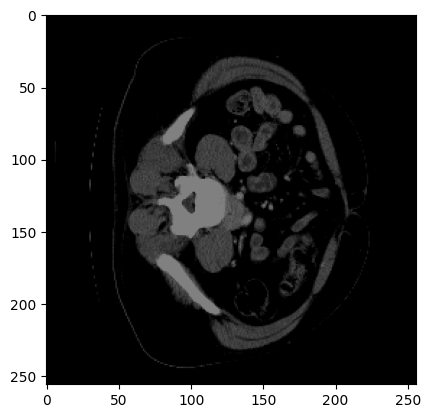

In [10]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.imshow(label, 'gray', alpha=0.5)

In [11]:
np.unique(label)

array([0])

In [12]:
img.dtype

torch.float32

In [13]:
class UNet_Attention_Transformer_Multiscale(nn.Module):
    def __init__(self, n_channels = 1, n_classes=1, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down4 = Down(128, 256 // factor)
        self.up1 = Up(256, 128 // factor, bilinear)
        self.up2 = Up(256, 64 // factor, bilinear)
        self.up3 = Up(128, 32 // factor, bilinear)
        self.up4 = Up(64, 16, bilinear)
        self.outc = OutConv(32, n_classes)


        '''位置编码'''
        self.pos = PositionEmbeddingLearned(128 // factor)

        '''空间注意力机制'''
        self.pam = PAM_Module(128)

        '''自注意力机制'''
        self.sdpa = ScaledDotProductAttention(128)

        '''残差多尺度连接'''
#         self.fuse1 = MultiConv(768, 256)
#         self.fuse2 = MultiConv(384, 128)
#         self.fuse3 = MultiConv(192, 64)
#         self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        #[x1,x2,x3,x4] = tskip([x1,x2,x3,x4],device = device, up=4)
        #print('x1: ', x1.shape)
        #print('x2: ', x2.shape)
        #print('x3: ', x3.shape)
        #print('x4: ', x4.shape)
        

        '''Setting 1'''
        x5_pam = self.pam(x5)
        '''Setting 2'''
        x5_pos = self.pos(x5)
        x5 = x5 + x5_pos


        x5_sdpa = self.sdpa(x5)
        x5 = x5_sdpa + x5_pam
        
        x6 = self.up1(x5, x4)
        x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
        x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up2(x6_cat, x3)
        x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up3(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up4(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits


In [14]:
model = UNet_Attention_Transformer_Multiscale()

In [15]:
model

UNet_Attention_Transformer_Multiscale(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): Batch

In [16]:
epochs = 400

In [17]:
model.to(device)

UNet_Attention_Transformer_Multiscale(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): Batch

In [18]:
optimizer = optim.SGD(model.parameters(), lr=1e-4)#, momentum=0.9)
torch.cuda.empty_cache()
max_dice = 0
train_losses = []
test_losses = []
train_dices = []
val_dices = []
decrease = 1  
not_improve=0

In [19]:

filename_sd = '/home/rabeea/logs/TransAttUnet_spleen/TransAttUNet_spleen_16_256_msa512_ly5_lr4_new.pth'

In [ ]:
fit_time = time.time()
for epoch in range(epochs):
    # Your dataset or data loading logic goes here
    since = time.time()
    # Training
    model.train()
    train_loss = 0
    train_dice = 0
    num_batches = 0
    
    for i,data in enumerate(tqdm(train_loader)):  # Replace train_loader with your data loader
        inputs, labels = data
        # Forward pass
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # Calculate loss
        loss = dice_loss(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_coeff(outputs, labels).item()
        num_batches += 1
    
    train_loss /= num_batches
    train_dice /= num_batches
    
    # Validation
    model.eval()
    val_dice = 0.0
    test_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)
            val_outputs = model(val_inputs)
            val_dice += dice_coeff(val_outputs,val_targets).item()
            test_loss += dice_loss(val_outputs,val_targets).item()
            
    val_dice /= len(val_loader)
    test_loss /= len(val_loader)
    # Perform validation and calculate validation loss and dice coefficient
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    if max_dice < val_dice:
        print('Dice increasing.. {:.3f} >> {:.3f} '.format(max_dice, val_dice))
        max_dice = val_dice
        decrease += 1
        not_improve = 0
        #if decrease % 5 == 0:
        print('saving model...')
        torch.save(model.state_dict(), filename_sd)
    if max_dice > val_dice:
        not_improve += 1
#         min_loss = test_loss
#         print(f'Loss Not Decrease for {not_improve} time')
        if not_improve == 30:
            print('Loss hasnt decreased for 30 epochs, Stopping Training')
            break
    
    # Print the metrics+
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, time: {((time.time() - since)/60):.2f}")

    

  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.000 >> 0.012 
saving model...
Epoch 1/400, Train Loss: 0.9921, Train Dice: 0.0079, Val Dice: 0.0116, time: 1.04


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.012 >> 0.012 
saving model...
Epoch 2/400, Train Loss: 0.9917, Train Dice: 0.0083, Val Dice: 0.0122, time: 0.85


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.012 >> 0.013 
saving model...
Epoch 3/400, Train Loss: 0.9912, Train Dice: 0.0088, Val Dice: 0.0128, time: 0.84


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.013 >> 0.013 
saving model...
Epoch 4/400, Train Loss: 0.9907, Train Dice: 0.0093, Val Dice: 0.0135, time: 0.86


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.013 >> 0.014 
saving model...
Epoch 5/400, Train Loss: 0.9902, Train Dice: 0.0098, Val Dice: 0.0142, time: 0.85


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.014 >> 0.015 
saving model...
Epoch 6/400, Train Loss: 0.9897, Train Dice: 0.0103, Val Dice: 0.0149, time: 0.85


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.015 >> 0.016 
saving model...
Epoch 7/400, Train Loss: 0.9891, Train Dice: 0.0109, Val Dice: 0.0157, time: 1.10


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.016 >> 0.016 
saving model...
Epoch 8/400, Train Loss: 0.9885, Train Dice: 0.0115, Val Dice: 0.0163, time: 1.11


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.016 >> 0.017 
saving model...
Epoch 9/400, Train Loss: 0.9880, Train Dice: 0.0120, Val Dice: 0.0169, time: 1.12


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.017 >> 0.018 
saving model...
Epoch 10/400, Train Loss: 0.9875, Train Dice: 0.0125, Val Dice: 0.0178, time: 1.14


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.018 >> 0.018 
saving model...
Epoch 11/400, Train Loss: 0.9870, Train Dice: 0.0130, Val Dice: 0.0182, time: 1.35


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.018 >> 0.019 
saving model...
Epoch 12/400, Train Loss: 0.9866, Train Dice: 0.0134, Val Dice: 0.0188, time: 1.70


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.019 >> 0.019 
saving model...
Epoch 13/400, Train Loss: 0.9862, Train Dice: 0.0138, Val Dice: 0.0191, time: 1.30


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.020 >> 0.020 
saving model...
Epoch 15/400, Train Loss: 0.9855, Train Dice: 0.0145, Val Dice: 0.0199, time: 2.16


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.020 >> 0.020 
saving model...
Epoch 16/400, Train Loss: 0.9852, Train Dice: 0.0148, Val Dice: 0.0204, time: 2.13


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.020 >> 0.021 
saving model...
Epoch 17/400, Train Loss: 0.9850, Train Dice: 0.0150, Val Dice: 0.0209, time: 2.09


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.021 >> 0.021 
saving model...
Epoch 18/400, Train Loss: 0.9848, Train Dice: 0.0152, Val Dice: 0.0213, time: 2.14


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.021 >> 0.021 
saving model...
Epoch 19/400, Train Loss: 0.9845, Train Dice: 0.0155, Val Dice: 0.0214, time: 2.06


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.022 >> 0.022 
saving model...
Epoch 21/400, Train Loss: 0.9841, Train Dice: 0.0159, Val Dice: 0.0221, time: 2.07


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.022 >> 0.022 
saving model...
Epoch 22/400, Train Loss: 0.9839, Train Dice: 0.0161, Val Dice: 0.0224, time: 2.16


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.022 >> 0.023 
saving model...
Epoch 23/400, Train Loss: 0.9837, Train Dice: 0.0163, Val Dice: 0.0225, time: 2.08


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.023 >> 0.023 
saving model...
Epoch 25/400, Train Loss: 0.9834, Train Dice: 0.0166, Val Dice: 0.0231, time: 2.05


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.023 >> 0.023 
saving model...
Epoch 27/400, Train Loss: 0.9831, Train Dice: 0.0169, Val Dice: 0.0235, time: 2.01


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 29/400, Train Loss: 0.9827, Train Dice: 0.0173, Val Dice: 0.0238, time: 2.09


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.024 >> 0.024 
saving model...
Epoch 31/400, Train Loss: 0.9824, Train Dice: 0.0176, Val Dice: 0.0245, time: 2.10


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.024 >> 0.025 
saving model...
Epoch 33/400, Train Loss: 0.9821, Train Dice: 0.0179, Val Dice: 0.0247, time: 1.99


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.025 >> 0.025 
saving model...
Epoch 34/400, Train Loss: 0.9820, Train Dice: 0.0180, Val Dice: 0.0249, time: 2.03


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.025 >> 0.026 
saving model...
Epoch 36/400, Train Loss: 0.9817, Train Dice: 0.0183, Val Dice: 0.0257, time: 2.07


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 37/400, Train Loss: 0.9815, Train Dice: 0.0185, Val Dice: 0.0257, time: 2.03


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.026 >> 0.026 
saving model...
Epoch 40/400, Train Loss: 0.9810, Train Dice: 0.0190, Val Dice: 0.0264, time: 2.12


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.027 >> 0.027 
saving model...
Epoch 44/400, Train Loss: 0.9804, Train Dice: 0.0196, Val Dice: 0.0272, time: 2.00


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 45/400, Train Loss: 0.9803, Train Dice: 0.0197, Val Dice: 0.0270, time: 2.11


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.028 >> 0.028 
saving model...
Epoch 47/400, Train Loss: 0.9799, Train Dice: 0.0201, Val Dice: 0.0280, time: 2.06


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 48/400, Train Loss: 0.9798, Train Dice: 0.0202, Val Dice: 0.0279, time: 2.07


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.028 >> 0.028 
saving model...
Epoch 50/400, Train Loss: 0.9794, Train Dice: 0.0206, Val Dice: 0.0284, time: 2.10


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.028 >> 0.029 
saving model...
Epoch 51/400, Train Loss: 0.9792, Train Dice: 0.0208, Val Dice: 0.0288, time: 2.09


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 53/400, Train Loss: 0.9789, Train Dice: 0.0211, Val Dice: 0.0290, time: 2.07


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.029 >> 0.029 
saving model...
Epoch 54/400, Train Loss: 0.9787, Train Dice: 0.0213, Val Dice: 0.0294, time: 2.04


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.030 >> 0.030 
saving model...
Epoch 56/400, Train Loss: 0.9783, Train Dice: 0.0217, Val Dice: 0.0302, time: 2.10


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.030 >> 0.031 
saving model...
Epoch 58/400, Train Loss: 0.9779, Train Dice: 0.0221, Val Dice: 0.0306, time: 2.08


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.031 >> 0.031 
saving model...
Epoch 59/400, Train Loss: 0.9777, Train Dice: 0.0223, Val Dice: 0.0308, time: 2.07


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.031 >> 0.031 
saving model...
Epoch 60/400, Train Loss: 0.9775, Train Dice: 0.0225, Val Dice: 0.0315, time: 2.06


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 62/400, Train Loss: 0.9771, Train Dice: 0.0229, Val Dice: 0.0315, time: 2.03


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.032 >> 0.032 
saving model...
Epoch 64/400, Train Loss: 0.9766, Train Dice: 0.0234, Val Dice: 0.0323, time: 2.13


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.033 >> 0.033 
saving model...
Epoch 67/400, Train Loss: 0.9759, Train Dice: 0.0241, Val Dice: 0.0332, time: 2.25


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.033 >> 0.034 
saving model...
Epoch 68/400, Train Loss: 0.9756, Train Dice: 0.0244, Val Dice: 0.0339, time: 2.27


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.034 >> 0.034 
saving model...
Epoch 69/400, Train Loss: 0.9754, Train Dice: 0.0246, Val Dice: 0.0339, time: 2.27


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.034 >> 0.034 
saving model...
Epoch 70/400, Train Loss: 0.9751, Train Dice: 0.0249, Val Dice: 0.0340, time: 2.26


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.035 >> 0.035 
saving model...
Epoch 72/400, Train Loss: 0.9745, Train Dice: 0.0255, Val Dice: 0.0352, time: 2.19


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.036 >> 0.036 
saving model...
Epoch 75/400, Train Loss: 0.9736, Train Dice: 0.0264, Val Dice: 0.0364, time: 2.22


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 76/400, Train Loss: 0.9732, Train Dice: 0.0268, Val Dice: 0.0364, time: 2.33


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.037 >> 0.038 
saving model...
Epoch 78/400, Train Loss: 0.9725, Train Dice: 0.0275, Val Dice: 0.0377, time: 2.24


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.038 >> 0.038 
saving model...
Epoch 79/400, Train Loss: 0.9722, Train Dice: 0.0278, Val Dice: 0.0380, time: 2.22


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.039 >> 0.039 
saving model...
Epoch 82/400, Train Loss: 0.9710, Train Dice: 0.0290, Val Dice: 0.0394, time: 2.19


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.040 >> 0.041 
saving model...
Epoch 85/400, Train Loss: 0.9697, Train Dice: 0.0303, Val Dice: 0.0412, time: 2.16


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.041 >> 0.042 
saving model...
Epoch 86/400, Train Loss: 0.9692, Train Dice: 0.0308, Val Dice: 0.0420, time: 2.20


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.042 >> 0.043 
saving model...
Epoch 88/400, Train Loss: 0.9682, Train Dice: 0.0318, Val Dice: 0.0431, time: 2.18


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.043 >> 0.043 
saving model...
Epoch 89/400, Train Loss: 0.9677, Train Dice: 0.0323, Val Dice: 0.0434, time: 2.10


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.044 >> 0.045 
saving model...
Epoch 91/400, Train Loss: 0.9666, Train Dice: 0.0334, Val Dice: 0.0450, time: 2.20


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.045 >> 0.046 
saving model...
Epoch 93/400, Train Loss: 0.9654, Train Dice: 0.0346, Val Dice: 0.0460, time: 2.19


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.047 >> 0.048 
saving model...
Epoch 95/400, Train Loss: 0.9641, Train Dice: 0.0359, Val Dice: 0.0475, time: 2.12


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.048 >> 0.048 
saving model...
Epoch 96/400, Train Loss: 0.9634, Train Dice: 0.0366, Val Dice: 0.0483, time: 2.20


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.050 >> 0.051 
saving model...
Epoch 98/400, Train Loss: 0.9620, Train Dice: 0.0380, Val Dice: 0.0505, time: 2.25


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.051 >> 0.051 
saving model...
Epoch 99/400, Train Loss: 0.9612, Train Dice: 0.0388, Val Dice: 0.0512, time: 2.46


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.053 >> 0.053 
saving model...
Epoch 101/400, Train Loss: 0.9596, Train Dice: 0.0404, Val Dice: 0.0528, time: 2.44


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.055 >> 0.056 
saving model...
Epoch 104/400, Train Loss: 0.9568, Train Dice: 0.0432, Val Dice: 0.0562, time: 1.74


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.056 >> 0.057 
saving model...
Epoch 105/400, Train Loss: 0.9558, Train Dice: 0.0442, Val Dice: 0.0565, time: 1.76


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.057 >> 0.058 
saving model...
Epoch 106/400, Train Loss: 0.9547, Train Dice: 0.0453, Val Dice: 0.0580, time: 1.65


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.060 >> 0.061 
saving model...
Epoch 108/400, Train Loss: 0.9524, Train Dice: 0.0476, Val Dice: 0.0608, time: 1.77


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.061 >> 0.062 
saving model...
Epoch 109/400, Train Loss: 0.9512, Train Dice: 0.0488, Val Dice: 0.0616, time: 1.78


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.062 >> 0.063 
saving model...
Epoch 110/400, Train Loss: 0.9499, Train Dice: 0.0501, Val Dice: 0.0631, time: 1.72


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.063 >> 0.064 
saving model...
Epoch 111/400, Train Loss: 0.9485, Train Dice: 0.0515, Val Dice: 0.0645, time: 1.72


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.066 >> 0.066 
saving model...
Epoch 113/400, Train Loss: 0.9456, Train Dice: 0.0544, Val Dice: 0.0664, time: 1.70


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.066 >> 0.069 
saving model...
Epoch 114/400, Train Loss: 0.9440, Train Dice: 0.0560, Val Dice: 0.0686, time: 1.73


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.072 >> 0.073 
saving model...
Epoch 117/400, Train Loss: 0.9386, Train Dice: 0.0614, Val Dice: 0.0734, time: 1.76


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.073 >> 0.074 
saving model...
Epoch 118/400, Train Loss: 0.9367, Train Dice: 0.0633, Val Dice: 0.0744, time: 1.59


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.078 >> 0.079 
saving model...
Epoch 120/400, Train Loss: 0.9323, Train Dice: 0.0677, Val Dice: 0.0787, time: 1.73


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.079 >> 0.081 
saving model...
Epoch 121/400, Train Loss: 0.9300, Train Dice: 0.0700, Val Dice: 0.0806, time: 1.72


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.082 >> 0.084 
saving model...
Epoch 123/400, Train Loss: 0.9250, Train Dice: 0.0750, Val Dice: 0.0843, time: 1.70


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.084 >> 0.086 
saving model...
Epoch 124/400, Train Loss: 0.9223, Train Dice: 0.0777, Val Dice: 0.0865, time: 1.69


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.089 >> 0.090 
saving model...
Epoch 126/400, Train Loss: 0.9164, Train Dice: 0.0836, Val Dice: 0.0895, time: 1.69


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.090 >> 0.090 
saving model...
Epoch 127/400, Train Loss: 0.9132, Train Dice: 0.0868, Val Dice: 0.0900, time: 1.66


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 129/400, Train Loss: 0.9065, Train Dice: 0.0935, Val Dice: 0.0952, time: 1.62


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.095 >> 0.096 
saving model...
Epoch 130/400, Train Loss: 0.9029, Train Dice: 0.0971, Val Dice: 0.0959, time: 1.76


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.099 >> 0.103 
saving model...
Epoch 132/400, Train Loss: 0.8954, Train Dice: 0.1046, Val Dice: 0.1030, time: 1.59


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.103 >> 0.104 
saving model...
Epoch 133/400, Train Loss: 0.8914, Train Dice: 0.1086, Val Dice: 0.1036, time: 1.64


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.108 >> 0.111 
saving model...
Epoch 136/400, Train Loss: 0.8790, Train Dice: 0.1210, Val Dice: 0.1106, time: 1.68


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.114 >> 0.119 
saving model...
Epoch 139/400, Train Loss: 0.8661, Train Dice: 0.1339, Val Dice: 0.1194, time: 1.68


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 140/400, Train Loss: 0.8618, Train Dice: 0.1382, Val Dice: 0.1173, time: 1.62


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.120 >> 0.126 
saving model...
Epoch 142/400, Train Loss: 0.8532, Train Dice: 0.1468, Val Dice: 0.1256, time: 1.76


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 143/400, Train Loss: 0.8490, Train Dice: 0.1510, Val Dice: 0.1219, time: 1.62


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.127 >> 0.130 
saving model...
Epoch 146/400, Train Loss: 0.8369, Train Dice: 0.1631, Val Dice: 0.1300, time: 1.66


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 149/400, Train Loss: 0.8256, Train Dice: 0.1744, Val Dice: 0.1325, time: 1.72


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.133 >> 0.136 
saving model...
Epoch 150/400, Train Loss: 0.8220, Train Dice: 0.1780, Val Dice: 0.1358, time: 1.69


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 152/400, Train Loss: 0.8154, Train Dice: 0.1846, Val Dice: 0.1344, time: 1.72


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 154/400, Train Loss: 0.8091, Train Dice: 0.1909, Val Dice: 0.1285, time: 1.62


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.136 >> 0.138 
saving model...
Epoch 155/400, Train Loss: 0.8063, Train Dice: 0.1937, Val Dice: 0.1385, time: 1.60


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 157/400, Train Loss: 0.8009, Train Dice: 0.1991, Val Dice: 0.1342, time: 1.65


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 158/400, Train Loss: 0.7985, Train Dice: 0.2015, Val Dice: 0.1336, time: 1.68


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 160/400, Train Loss: 0.7939, Train Dice: 0.2061, Val Dice: 0.1396, time: 1.67


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.143 >> 0.146 
saving model...
Epoch 161/400, Train Loss: 0.7915, Train Dice: 0.2085, Val Dice: 0.1458, time: 1.62


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 164/400, Train Loss: 0.7856, Train Dice: 0.2144, Val Dice: 0.1396, time: 1.73


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 165/400, Train Loss: 0.7837, Train Dice: 0.2163, Val Dice: 0.1456, time: 1.62


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 168/400, Train Loss: 0.7785, Train Dice: 0.2215, Val Dice: 0.1391, time: 1.70


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 169/400, Train Loss: 0.7769, Train Dice: 0.2231, Val Dice: 0.1344, time: 1.59


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 172/400, Train Loss: 0.7726, Train Dice: 0.2274, Val Dice: 0.1397, time: 1.71


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 176/400, Train Loss: 0.7671, Train Dice: 0.2329, Val Dice: 0.1408, time: 1.65


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 177/400, Train Loss: 0.7661, Train Dice: 0.2339, Val Dice: 0.1310, time: 1.70


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 179/400, Train Loss: 0.7633, Train Dice: 0.2367, Val Dice: 0.1418, time: 1.73


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 182/400, Train Loss: 0.7596, Train Dice: 0.2404, Val Dice: 0.1326, time: 1.64


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 183/400, Train Loss: 0.7583, Train Dice: 0.2417, Val Dice: 0.1394, time: 1.63


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 185/400, Train Loss: 0.7563, Train Dice: 0.2437, Val Dice: 0.1385, time: 1.69


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 186/400, Train Loss: 0.7555, Train Dice: 0.2445, Val Dice: 0.1342, time: 1.70


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 189/400, Train Loss: 0.7518, Train Dice: 0.2482, Val Dice: 0.1393, time: 1.71


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 191/400, Train Loss: 0.7500, Train Dice: 0.2500, Val Dice: 0.1404, time: 1.71


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 192/400, Train Loss: 0.7482, Train Dice: 0.2518, Val Dice: 0.1328, time: 1.67


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.149 >> 0.158 
saving model...
Epoch 196/400, Train Loss: 0.7423, Train Dice: 0.2577, Val Dice: 0.1577, time: 1.73


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 197/400, Train Loss: 0.7410, Train Dice: 0.2590, Val Dice: 0.1372, time: 1.67


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 199/400, Train Loss: 0.7376, Train Dice: 0.2624, Val Dice: 0.1399, time: 1.65


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.158 >> 0.175 
saving model...
Epoch 200/400, Train Loss: 0.7367, Train Dice: 0.2633, Val Dice: 0.1754, time: 1.66


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 201/400, Train Loss: 0.7343, Train Dice: 0.2657, Val Dice: 0.1416, time: 1.68


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 203/400, Train Loss: 0.7293, Train Dice: 0.2707, Val Dice: 0.1374, time: 1.64


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 205/400, Train Loss: 0.7235, Train Dice: 0.2765, Val Dice: 0.1539, time: 1.68


  0%|          | 0/2463 [00:00<?, ?it/s]

Epoch 206/400, Train Loss: 0.7201, Train Dice: 0.2799, Val Dice: 0.1510, time: 1.67


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 209/400, Train Loss: 0.7031, Train Dice: 0.2969, Val Dice: 0.1735, time: 1.73


  0%|          | 0/2463 [00:00<?, ?it/s]

Dice increasing.. 0.175 >> 0.187 
saving model...
Epoch 210/400, Train Loss: 0.6929, Train Dice: 0.3071, Val Dice: 0.1873, time: 1.61


  0%|          | 0/2463 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Dice increasing.. 0.218 >> 0.244 
saving model...
Epoch 213/400, Train Loss: 0.6292, Train Dice: 0.3708, Val Dice: 0.2443, time: 1.64


  0%|          | 0/2463 [00:00<?, ?it/s]

In [ ]:
model.load_state_dict(torch.load(filename_sd))

In [ ]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_dice' :train_dices, 'val_dice':val_dices}
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
test_dice005 = []
test_dice001 = []
test_dice0005 = []
test_dice0001 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.005,torch.tensor(1),torch.tensor(0))
        test_dice005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.001,torch.tensor(1),torch.tensor(0))
        test_dice001.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0005,torch.tensor(1),torch.tensor(0))
        test_dice0005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0001,torch.tensor(1),torch.tensor(0))
        test_dice0001.append(dice_coeff(test_outputs,val_targets).item())
        
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))
print('Test dice at 0.005: ',np.mean(test_dice005))
print('Test dice at 0.001: ',np.mean(test_dice001))
print('Test dice at 0.0005: ',np.mean(test_dice0005))
print('Test dice at 0.0001: ',np.mean(test_dice0001))

# TransAttUNet_spleen_16_256_msa512_ly5_lr4_new.pth

In [26]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

max training dice:  0.9841809152289726
max validation dice:  0.7827060454069044


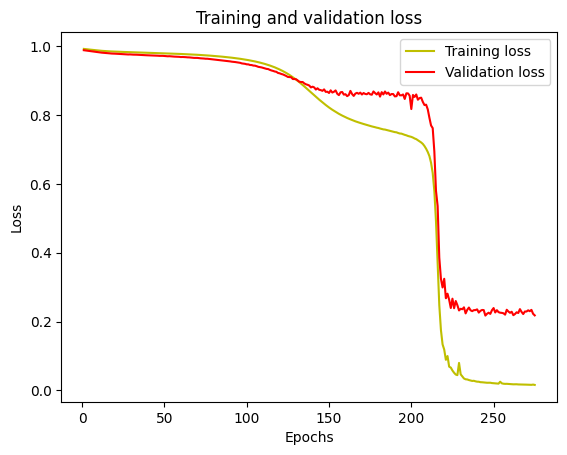

In [27]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

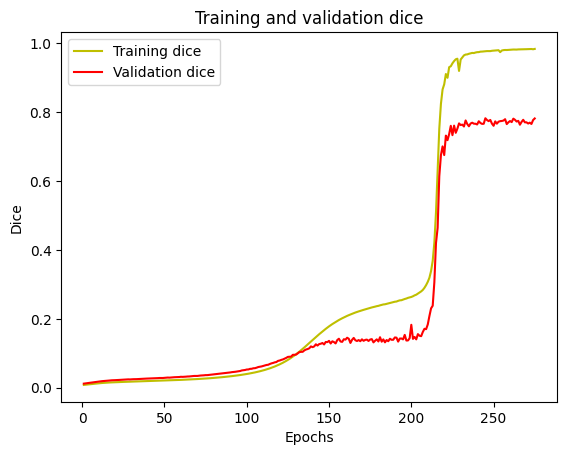

In [28]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [31]:
num_batches = 1
# Validation
model.eval()
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
test_dice005 = []
test_dice001 = []
test_dice0005 = []
test_dice0001 = []
with torch.no_grad():
    for val_inputs, val_targets in tqdm(test_loader):
        val_inputs = val_inputs.to(device)
        val_targets = val_targets.to(device)
        val_outputs = model(val_inputs)
        #print(np.unique(val_outputs))
        test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
        test_dice9.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
        test_dice8.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
        test_dice7.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
        test_dice6.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
        test_dice5.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
        test_dice4.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
        test_dice3.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
        test_dice2.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
        test_dice1.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
        test_dice05.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
        test_dice01.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.005,torch.tensor(1),torch.tensor(0))
        test_dice005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.001,torch.tensor(1),torch.tensor(0))
        test_dice001.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0005,torch.tensor(1),torch.tensor(0))
        test_dice0005.append(dice_coeff(test_outputs,val_targets).item())
        test_outputs = torch.where(val_outputs>0.0001,torch.tensor(1),torch.tensor(0))
        test_dice0001.append(dice_coeff(test_outputs,val_targets).item())
        
        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))
print('Test dice at 0.005: ',np.mean(test_dice005))
print('Test dice at 0.001: ',np.mean(test_dice001))
print('Test dice at 0.0005: ',np.mean(test_dice0005))
print('Test dice at 0.0001: ',np.mean(test_dice0001))

  0%|          | 0/801 [00:00<?, ?it/s]

Test dice at 0.9:  0.8320514016124386
Test dice at 0.8:  0.8396183305585884
Test dice at 0.7:  0.8441423332330945
Test dice at 0.6:  0.8476693622967982
Test dice at 0.5:  0.8506271612194827
Test dice at 0.4:  0.8533961370238321
Test dice at 0.3:  0.8565681978979002
Test dice at 0.2:  0.8584492720990048
Test dice at 0.1:  0.8621343965161451
Test dice at 0.05:  0.8658962244964445
Test dice at 0.01:  0.8714850586691503
Test dice at 0.005:  0.8744491434682027
Test dice at 0.001:  0.8770972381157498
Test dice at 0.0005:  0.8769232701166032
Test dice at 0.0001:  0.876554874246674
